# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [2]:
import torch
torch.__version__

'1.0.0'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [3]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

test_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [4]:
model = models.densenet121(pretrained=True)
model

/Users/ysun/anaconda2/lib/python2.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [5]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [6]:
import time

In [25]:
next(iter(trainloader))

[tensor([[[[-0.4397, -0.1828, -0.0972,  ...,  0.5193,  0.5364,  0.5536],
           [-0.5253, -0.4054, -0.3369,  ...,  0.4679,  0.4679,  0.4337],
           [-0.5424, -0.5596, -0.5082,  ...,  0.3652,  0.3138,  0.2282],
           ...,
           [ 0.6392,  0.6392,  0.6221,  ..., -0.2513, -0.2342, -0.2171],
           [ 0.7248,  0.7248,  0.6734,  ..., -0.2342, -0.2171, -0.1828],
           [ 0.8618,  0.8104,  0.7248,  ..., -0.1828, -0.1486, -0.1143]],
 
          [[-0.5126, -0.2500, -0.1625,  ...,  0.7129,  0.7479,  0.7654],
           [-0.6001, -0.4776, -0.4076,  ...,  0.6604,  0.6779,  0.6429],
           [-0.6176, -0.6352, -0.5826,  ...,  0.5553,  0.5028,  0.4328],
           ...,
           [ 0.6779,  0.6779,  0.6604,  ..., -0.1975, -0.1800, -0.1625],
           [ 0.7654,  0.7654,  0.7129,  ..., -0.1800, -0.1625, -0.1275],
           [ 0.9055,  0.8529,  0.7654,  ..., -0.1625, -0.1275, -0.0924]],
 
          [[-0.1487,  0.1128,  0.1651,  ...,  1.8208,  1.8034,  1.8034],
           [-

In [42]:
image = next(iter(trainloader))[0].numpy()

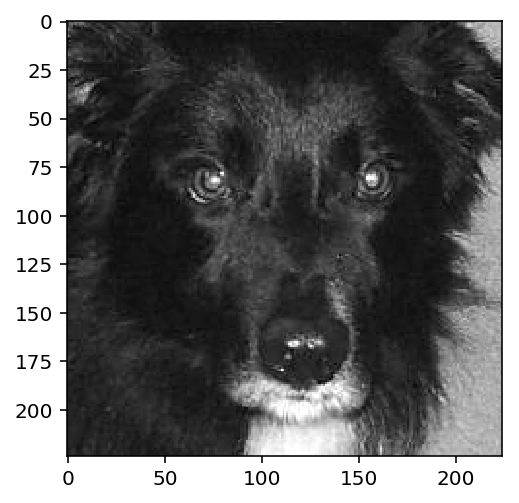

In [54]:
image[0][0].shape
#plt.imshow(image[0][0])
plt.imshow(image[1][1], cmap="gray")

In [7]:
#for device in ['cpu', 'cuda']:
for device in ['cpu']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    #print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")
    print(device)
    print(time.time()-start)

cpu
25.2766621113


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [ ]:
## TODO: Use a pretrained model to classify the cat and dog images


epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in testloader:
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            print(epoch+1/epochs)
            print(running_loss/print_every)
            print(test_loss/len(testloader))
            print(accuracy/len(testloader))
            #print(f"Epoch {epoch+1}/{epochs}.. "
            #          f"Train loss: {running_loss/print_every:.3f}.. "
            #          f"Test loss: {test_loss/len(testloader):.3f}.. "
            #          f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()




1
0.353123748302
0.144858601131
0.94296875
1
0.188358125091
0.193783603422
0.921484375
1
0.22828784287
0.0925997191574
0.965234375
1
0.10492618978
0.126157609001
0.952734375
1
0.155114480853
0.102726240014
0.959765625
1
0.142561259866
0.0798279500566
0.966796875
1
0.142665161192
0.0974125612061
0.96328125
1
0.0892664127052
0.0985599310137
0.95859375
1
0.121132041514
0.106521859067
0.95703125
1
0.0876240417361
0.0770363059128
0.970703125
1
0.117128092051
0.0752282636706
0.970703125
1
0.0762780308723
0.111500405567
0.958203125
1
0.147730436921
0.0763212966733
0.970703125
1
0.173644959927
0.100337279076
0.957421875
1
0.14259468019
0.13410452141
0.947265625
1
0.130577073991
0.0756438616198
0.971484375
1
0.0830349557102
0.0852415233385
0.9640625
1
0.106508993357
0.0825618634466
0.966796875
1
0.0829711489379
0.0999277142109
0.959765625
1
0.0770017720759
0.0763985150028
0.97109375
